# Component-wise 24 Hr Model

## Data Prep

### Loading and Building Signal

In [1]:
%cd ../..
from src.data.files import Data
from src.data.synthesizer import MachineSignalSynth, OneHotColumn, JoinColumns, ConvolveBoleanColumns

import pandas as pd
from sklearn.model_selection import train_test_split

COMPONENT = "comp2"
JOIN_COLS = ["error" + str(i) for i in range(1,6)]
JOIN_COLS.extend(["maint_comp" + str(i) for i in range(1,5)])
JOIN_COLS.append("failure_" + COMPONENT)

LABEL = "failure_" + COMPONENT
all_events = Data.get_events()
tel = Data.get_telemetry()
synthesizer_methods = [JoinColumns(JOIN_COLS),
                       OneHotColumn("model"),
                       ConvolveBoleanColumns(cols=JOIN_COLS,
                                             in_place=[False]*(len(JOIN_COLS) - 1) + [True],
                                             delta_ts=[24]*len(JOIN_COLS))]
synthesizer = MachineSignalSynth(tel, all_events, synthesizer_methods)
raw_signal = synthesizer.generate()

/Users/legross/Code/marching-penguin


In [2]:
ANOMALY = "anomaly"
MODEL = "model"

raw_signal[ANOMALY] = raw_signal[ANOMALY].astype(int)

### Signal Description/Verification

From the all_events data, let's take a look at the first two failures,

In [29]:
all_events.loc[all_events.failure_comp2 == True].head(2)

,datetime,machineID,failure_comp1,failure_comp2,failure_comp3,failure_comp4,maint_comp1,maint_comp2,maint_comp3,maint_comp4,error1,error2,error3,error4,error5,failure,maint,error,anomaly
2616,2015-04-20 06:00:00,1,0,1,0,0,0,1,0,0,0,0,0,0,0,True,True,False,True
6936,2015-10-17 06:00:00,1,0,1,0,0,0,1,0,1,0,0,0,0,0,True,True,False,True


The first failure occurs at time stamp "2015-04-20 06:00:00." Our label "failure_comp2" is in the 18th column of the signal. At that time step we expect the label to be 1.0 or True for machineID 1,

In [36]:
raw_signal.loc[(raw_signal.datetime == "2015-04-20 06:00:00") & (raw_signal.machineID == 1)].iloc[:, :18]

,datetime,machineID,volt,rotate,pressure,vibration,age,anomaly,error1,error2,error3,error4,error5,maint_comp1,maint_comp2,maint_comp3,maint_comp4,failure_comp2
2616,2015-04-20 06:00:00,1,180.050801,346.36248,105.661164,39.218055,18,1,0,0,0,0,0,0,1,0,0,1.0


The convolution filter is such that the labels will be 1.0 for all data points in the past 24 hours, but 0 after the event has occured.

In [42]:
machine_1_signal = raw_signal.loc[raw_signal.machineID == 1]
mask = (machine_1_signal['datetime'] > "2015-04-19 03:00:00") & (machine_1_signal['datetime'] <= "2015-04-20 09:00:00")
machine_1_signal[mask][["datetime", LABEL]]

,datetime,failure_comp2
2590,2015-04-19 04:00:00,0.0
2591,2015-04-19 05:00:00,0.0
2592,2015-04-19 06:00:00,0.0
2593,2015-04-19 07:00:00,1.0
2594,2015-04-19 08:00:00,1.0
2595,2015-04-19 09:00:00,1.0
2596,2015-04-19 10:00:00,1.0
2597,2015-04-19 11:00:00,1.0
2598,2015-04-19 12:00:00,1.0
2599,2015-04-19 13:00:00,1.0


In [3]:
raw_signal.head()

,datetime,machineID,volt,rotate,pressure,vibration,age,anomaly,error1,error2,...,model4,error1_convolve_24,error2_convolve_24,error3_convolve_24,error4_convolve_24,error5_convolve_24,maint_comp1_convolve_24,maint_comp2_convolve_24,maint_comp3_convolve_24,maint_comp4_convolve_24
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,18,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
455572,2015-01-01 06:00:00,53,183.084582,420.980061,109.235805,45.737760,5,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
858578,2015-01-01 06:00:00,99,168.596133,384.747105,110.921131,41.944692,14,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96371,2015-01-01 06:00:00,12,171.404215,576.923563,97.145400,47.725909,9,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43805,2015-01-01 06:00:00,6,136.878588,492.088420,149.003582,22.973289,7,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


New column label shows whether a machine's compenent will fail in the next 72 hours. Let's look at signal points where the new column is true,

In [4]:
raw_signal.loc[raw_signal[LABEL] == True]

,datetime,machineID,volt,rotate,pressure,vibration,age,anomaly,error1,error2,...,model4,error1_convolve_24,error2_convolve_24,error3_convolve_24,error4_convolve_24,error5_convolve_24,maint_comp1_convolve_24,maint_comp2_convolve_24,maint_comp3_convolve_24,maint_comp4_convolve_24
499377,2015-01-01 06:00:00,58,196.874272,439.064185,97.176565,39.689021,5,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
692119,2015-01-01 06:00:00,80,187.489605,443.209039,101.054717,33.702281,6,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
630792,2015-01-01 06:00:00,73,167.639992,376.739783,139.337870,38.120657,20,1,0,0,...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
692120,2015-01-01 07:00:00,80,151.114448,303.530318,77.519149,29.228292,6,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
630793,2015-01-01 07:00:00,73,160.964174,304.508240,134.698681,33.707457,20,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17445,2015-12-29 02:00:00,2,154.391321,336.716867,85.480348,39.061929,7,0,0,0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17446,2015-12-29 03:00:00,2,180.299390,376.813609,99.011382,44.147377,7,0,0,0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17447,2015-12-29 04:00:00,2,136.025764,275.934792,80.103905,41.957460,7,0,0,0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17448,2015-12-29 05:00:00,2,174.440209,387.066947,95.294889,39.703843,7,0,0,0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [5]:
print(f"Failure vs normal labels: {len(raw_signal.loc[raw_signal[LABEL] == True].index) / len(raw_signal.index) * 100} %")

Failure vs normal labels: 0.7088231936993493 %


## Train/Val/Test Splitting

In [6]:
y = raw_signal.loc[:, raw_signal.columns == LABEL]
X = raw_signal.loc[:, raw_signal.columns != LABEL]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=False)

### Sanity Check

Training data starts at earlier timestamps.

In [7]:
X_train.head()

,datetime,machineID,volt,rotate,pressure,vibration,age,anomaly,error1,error2,...,model4,error1_convolve_24,error2_convolve_24,error3_convolve_24,error4_convolve_24,error5_convolve_24,maint_comp1_convolve_24,maint_comp2_convolve_24,maint_comp3_convolve_24,maint_comp4_convolve_24
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,18,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
455572,2015-01-01 06:00:00,53,183.084582,420.980061,109.235805,45.737760,5,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
858578,2015-01-01 06:00:00,99,168.596133,384.747105,110.921131,41.944692,14,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96371,2015-01-01 06:00:00,12,171.404215,576.923563,97.145400,47.725909,9,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43805,2015-01-01 06:00:00,6,136.878588,492.088420,149.003582,22.973289,7,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Validation is later.

In [8]:
X_val

,datetime,machineID,volt,rotate,pressure,vibration,age,anomaly,error1,error2,...,model4,error1_convolve_24,error2_convolve_24,error3_convolve_24,error4_convolve_24,error5_convolve_24,maint_comp1_convolve_24,maint_comp2_convolve_24,maint_comp3_convolve_24,maint_comp4_convolve_24
250564,2015-08-08 06:00:00,29,171.282232,481.209996,102.743036,39.519892,3,0,0,0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
408262,2015-08-08 06:00:00,47,178.795044,426.146721,105.017558,39.001777,6,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
662331,2015-08-08 06:00:00,76,183.061932,449.149734,98.230997,45.061041,10,0,0,0,...,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
574721,2015-08-08 06:00:00,66,164.209160,412.533084,93.624311,41.463793,6,0,0,0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
487111,2015-08-08 06:00:00,56,177.870183,449.365869,94.093720,45.531205,10,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366209,2015-10-20 06:00:00,42,158.452457,405.129364,106.064339,34.101076,7,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
629039,2015-10-20 06:00:00,72,164.552195,376.148556,93.900139,40.664033,2,0,0,0,...,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
226033,2015-10-20 06:00:00,26,172.369838,455.760415,103.049543,38.858137,3,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
681605,2015-10-20 06:00:00,78,179.076624,449.013090,82.255674,50.094108,19,0,0,0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Formatting for Sagemaker

In [16]:
train = pd.concat([y_train, X_train], axis=1)
validation = pd.concat([y_val, X_val], axis=1)
test = pd.concat([y_test, X_test], axis=1)

In [17]:
# Use 'csv' format to store the data
# The first column is expected to be the output column
train.to_csv('train.csv', index=False, header=False)
validation.to_csv('validation.csv', index=False, header=False)
test.to_csv('test.csv', index=False, header=False)

### Upload Data for Training, Validation, and Testing

In [18]:
import sagemaker, boto3, os
bucket = "pmpf-data"
prefix = "sagemaker-xgboost-prediction"

boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/validation.csv')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/test.csv')).upload_file('test.csv')

## Local Model Development/Analysis

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
# from xgboost import XGBClassifier

In [10]:
model_a = DecisionTreeClassifier(max_depth=3)
# model_a = XGBClassifier()
# Removing dates
model_a.fit(X_train.iloc[:, 1:],y_train)

DecisionTreeClassifier(max_depth=3)

In [11]:
y_pred = model_a.predict(X_train.iloc[:, 1:])
print("Train AUC:",metrics.roc_auc_score(y_train, y_pred))

Train AUC: 0.8467764994345272


In [12]:
y_pred = model_a.predict(X_test.iloc[:, 1:])
print("Test AUX:",metrics.roc_auc_score(y_test, y_pred))

Test AUX: 0.8453362386664437


In [13]:
metrics.confusion_matrix(y_test, y_pred)

array([[173624,    372],
       [   376,    848]])

In [14]:
list(X_train.columns)

['datetime',
 'machineID',
 'volt',
 'rotate',
 'pressure',
 'vibration',
 'age',
 'anomaly',
 'error1',
 'error2',
 'error3',
 'error4',
 'error5',
 'maint_comp1',
 'maint_comp2',
 'maint_comp3',
 'maint_comp4',
 'model1',
 'model2',
 'model3',
 'model4',
 'error1_convolve_24',
 'error2_convolve_24',
 'error3_convolve_24',
 'error4_convolve_24',
 'error5_convolve_24',
 'maint_comp1_convolve_24',
 'maint_comp2_convolve_24',
 'maint_comp3_convolve_24',
 'maint_comp4_convolve_24']

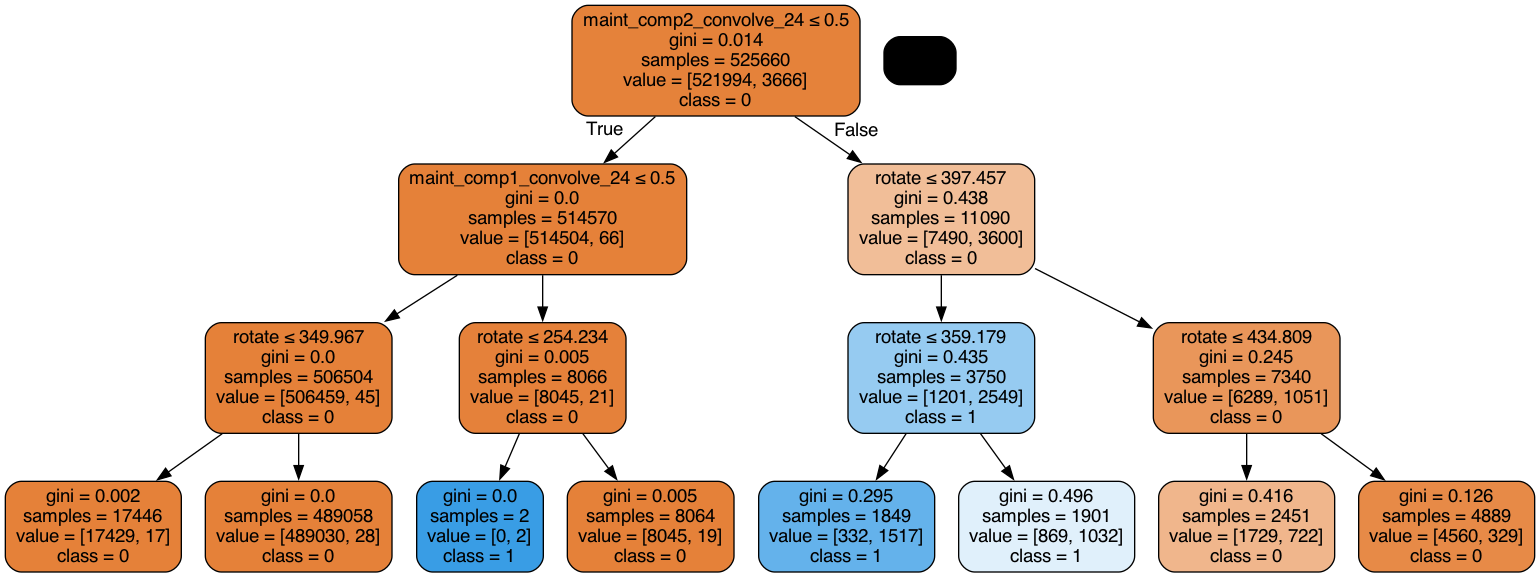

In [15]:
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model_a, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=list(X_train.columns)[1:], class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decision_tree.png')
Image(graph.create_png())

## Model Training In Sagemaker

In [19]:
region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))
role = 'arn:aws:iam::328535504136:role/service-role/AmazonSageMaker-ExecutionRole-20230208T093579'
print("RoleArn: {}".format(role))

AWS Region: us-west-1
RoleArn: arn:aws:iam::328535504136:role/service-role/AmazonSageMaker-ExecutionRole-20230208T093579


In [20]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput

s3_output_location='s3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model')

container=sagemaker.image_uris.retrieve("xgboost", region, "1.2-1")
print(container)

xgb_model=sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    volume_size=5,
    output_path=s3_output_location,
    sagemaker_session=sagemaker.Session(),
    rules=[Rule.sagemaker(rule_configs.create_xgboost_report())]
)
xgb_model.set_hyperparameters(
    max_depth = 5,
    eta = 0.2,
    gamma = 4,
    min_child_weight = 6,
    subsample = 0.7,
    objective = "binary:logistic",
    num_round = 500
)

746614075791.dkr.ecr.us-west-1.amazonaws.com/sagemaker-xgboost:1.2-1


In [21]:
from sagemaker.session import TrainingInput
train_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "data/train.csv"), content_type="csv"
)
validation_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "data/validation.csv"), content_type="csv"
)

#### TRAIN MODEL

In [22]:
xgb_model.fit({"train": train_input, "validation": validation_input}, wait=True)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-02-11-23-45-01-779


2023-02-11 23:45:03 Starting - Starting the training job...
2023-02-11 23:45:30 Starting - Preparing the instances for trainingCreateXgboostReport: InProgress
......
2023-02-11 23:46:24 Downloading - Downloading input data...
2023-02-11 23:47:00 Training - Downloading the training image......
2023-02-11 23:48:00 Training - Training image download completed. Training in progress..[2023-02-11 23:48:02.740 ip-10-0-119-194.us-west-1.compute.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delim

#### Deploy Model to Sagemaker

In [43]:
from sagemaker.serializers import CSVSerializer
xgb_predictor=xgb_model.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    serializer=CSVSerializer()
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-02-12-00-09-14-542
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-02-12-00-09-14-542
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-02-12-00-09-14-542


-------!

In [44]:
xgb_predictor.endpoint_name

'sagemaker-xgboost-2023-02-12-00-09-14-542'

## Evaluation

Getting predictions for the test set from the cloud model.

In [61]:
import numpy as np
def predict(data, rows=1000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep=',')

### Arbitrary Cutoff

With an arbitrary cutoff, the confusion matrix is,

In [62]:
import sklearn

cutoff=0.5
print(sklearn.metrics.confusion_matrix(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))

[[173614    382]
 [   536    688]]


The classification report is as follows, (note especially precision, recall, and f1-score, for postive labels 1.0)

In [51]:
print(sklearn.metrics.classification_report(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    173996
         1.0       0.64      0.56      0.60      1224

    accuracy                           0.99    175220
   macro avg       0.82      0.78      0.80    175220
weighted avg       0.99      0.99      0.99    175220



### "Improved" Cutoff

In predictive maintenance, false negatives tend to be the most costly, so by lowering the cutoff we can reduce the false negatives at the expense of an increased number of false positives.

In [69]:
cutoff=0.2
print(sklearn.metrics.confusion_matrix(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))

[[173216    780]
 [   282    942]]


Recall increases to 0.77 which means we catch more failures beforehand.

In [70]:
print(sklearn.metrics.classification_report(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    173996
         1.0       0.55      0.77      0.64      1224

    accuracy                           0.99    175220
   macro avg       0.77      0.88      0.82    175220
weighted avg       1.00      0.99      0.99    175220

